In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

## The WeRateDogs Twitter archive

In [2]:
# read data from "twitter_archive_enhanced.csv" into a dataframe
df_twitter_archive_enhanced = pd.read_csv("twitter-archive-enhanced.csv")
df_twitter_archive_enhanced.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


## The tweet image predictions

In [3]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

In [4]:
# download image_predictions.tsv through request and response
response = requests.get(url)

# Save response to file
with open("image_predictions.tsv", mode='wb') as file:
    file.write(response.content)

In [5]:
# laod image_prediction.tsv into dataframe
df_image_prediction = pd.read_csv("image_predictions.tsv", sep='\t')
df_image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
df_image_prediction.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


## Additional data from the Twitter API - tweet ID, retweet count, and favorite count      

In [5]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = '---'
consumer_secret = '---'
access_token = '---'
access_secret = '---'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [6]:
# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_twitter_archive_enhanced is a DataFrame with the twitter_archive_enhanced.csv file. 
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_twitter_archive_enhanced.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        #print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            #print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except Exception as e:
            #print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)


Rate limit reached. Sleeping for: 769
Rate limit reached. Sleeping for: 773


1880.5679886
{888202515573088257: NotFound('404 Not Found\n144 - No status found with that ID.'), 873697596434513921: NotFound('404 Not Found\n144 - No status found with that ID.'), 872668790621863937: NotFound('404 Not Found\n144 - No status found with that ID.'), 872261713294495745: NotFound('404 Not Found\n144 - No status found with that ID.'), 869988702071779329: NotFound('404 Not Found\n144 - No status found with that ID.'), 866816280283807744: NotFound('404 Not Found\n144 - No status found with that ID.'), 861769973181624320: NotFound('404 Not Found\n144 - No status found with that ID.'), 856602993587888130: NotFound('404 Not Found\n144 - No status found with that ID.'), 856330835276025856: NotFound('404 Not Found\n144 - No status found with that ID.'), 851953902622658560: NotFound('404 Not Found\n144 - No status found with that ID.'), 851861385021730816: NotFound('404 Not Found\n144 - No status found with that ID.'), 845459076796616705: NotFound('404 Not Found\n144 - No status f

### read retweet count and favorite count code into a dataframe is in another ipynb

In [7]:
df_list = []

with open('tweet_json.txt', encoding='UTF-8') as json_file:
    count = 0
    while True:
        line = json_file.readline()[:-1]
        count += 1
        jason_line = json.loads(line)
        
        tweet_id = jason_line['id']
        retweet_count = jason_line['retweet_count']
        favorite_count = jason_line['favorite_count']
        
        print(tweet_id, retweet_count, favorite_count)
        
        df_list.append({'tweet_id': tweet_id,
                        'retweet_count': retweet_count,
                        'favorite_count': favorite_count})

        
        #if count == 2:
            #break

892420643555336193 6976 33700
892177421306343426 5279 29232
891815181378084864 3466 21974
891689557279858688 7190 36779
891327558926688256 7723 35167
891087950875897856 2586 17738
890971913173991426 1649 10324
890729181411237888 15693 56641
890609185150312448 3605 24436
890240255349198849 6075 27846
890006608113172480 6119 26955
889880896479866881 4142 24496
889665388333682689 8309 41870
889638837579907072 3702 23574
889531135344209921 1874 13306
889278841981685760 4426 22015
888917238123831296 3746 25522
888804989199671297 3517 22386
888554962724278272 2867 17254
888078434458587136 2885 19093
887705289381826560 4521 26525
887517139158093824 9817 40562
887473957103951883 14968 59969
887343217045368832 8785 29479
887101392804085760 4972 26887
886983233522544640 6292 30255
886736880519319552 2619 10460
886680336477933568 3723 19655
886366144734445568 2613 18494
886267009285017600 4 105
886258384151887873 5258 24444
886054160059072513 93 0
885984800019947520 5590 28493
885528943205470208 

749317047558017024 2039 5085
749075273010798592 1879 5353
749064354620928000 1402 4490
749036806121881602 728 2881
748977405889503236 3124 10002
748932637671223296 2051 5401
748705597323898880 874 2582
748699167502000129 1452 4399
748692773788876800 1224 3945
748575535303884801 1802 5620
748568946752774144 606 2039
748346686624440324 1119 4840
748337862848962560 3723 7038
748324050481647620 689 3444
748307329658011649 652 3438
748220828303695873 7087 13105
747963614829678593 1950 5367
747933425676525569 2346 6161
747885874273214464 878 2716
747844099428986880 673 2616
747816857231626240 1053 4491
747651430853525504 143 1269
747648653817413632 5308 11934
747600769478692864 520 2161
747594051852075008 946 3408
747512671126323200 1470 5116
747461612269887489 938 3581
747439450712596480 1749 5025
747242308580548608 2620 0
747219827526344708 1433 4881
747204161125646336 828 3119
747103485104099331 3612 8857
746906459439529985 269 2711
746872823977771008 1935 5548
746818907684614144 1591 494

674781762103414784 1043 1801
674774481756377088 407 985
674767892831932416 689 1626
674764817387900928 200 699
674754018082705410 382 1229
674752233200820224 399 1309
674743008475090944 465 1259
674742531037511680 44 432
674739953134403584 326 968
674737130913071104 80 581
674690135443775488 411 1024
674670581682434048 565 1448
674664755118911488 205 810
674646392044941312 429 1279
674644256330530816 241 925
674638615994089473 509 1515
674632714662858753 501 1339
674606911342424069 86 841
674468880899788800 1774 5549
674447403907457024 314 953
674436901579923456 344 988
674422304705744896 464 1280
674416750885273600 115 612
674410619106390016 400 1067
674394782723014656 487 1333
674372068062928900 280 769
674330906434379776 65 505
674318007229923329 449 1252
674307341513269249 6018 10115
674291837063053312 5130 13151
674271431610523648 644 1393
674269164442398721 202 824
674265582246694913 727 1457
674262580978937856 382 1176
674255168825880576 464 1299
674082852460433408 144 680
67407

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [8]:
# extract tweet_id, retweet_count, favorite_count into a dataframe
df_addn_column = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

In [9]:
# write the above to a csv file
df_addn_column.to_csv('additional_columns.csv', index=False)

# Make a copy of all the three dataframes each
- **df_twitter_archive_enhanced -> df_twitter_archive_enhanced_copy**
- **df_image_prediction -> df_image_prediction_copy**
- **df_addn_column -> df_addn_column_copy**
# Note: since my code were written for the original copy of all the dataframes, I am saving the copis for reference. 

In [10]:
df_twitter_archive_enhanced_copy = df_twitter_archive_enhanced.copy()
df_image_prediction_copy = df_image_prediction.copy()
df_addn_column_copy = df_addn_column.copy()

# The following sections are data Access

In [11]:
df_twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [12]:
df_twitter_archive_enhanced.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [13]:
df_twitter_archive_enhanced.query("name == 'O'").name.count()

1

In [14]:
# check how many names start with lowercase (or all lowercases)
name_in_lowercase = df_twitter_archive_enhanced['name'].map(lambda name: name.islower())
name_in_lowercase.value_counts()

False    2247
True      109
Name: name, dtype: int64

In [15]:
# check duplications
duplicated_rows = df_twitter_archive_enhanced[df_twitter_archive_enhanced.duplicated(subset=['tweet_id'])]
duplicated_rows

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [16]:
df_image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [17]:
#check for duplication of df_image_prediction
df_image_prediction[df_image_prediction.duplicated(subset=['tweet_id'])]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [18]:
df_addn_column.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2327 non-null   int64
 1   retweet_count   2327 non-null   int64
 2   favorite_count  2327 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


In [19]:
# check for duplication of df_addn_column
df_addn_column[df_addn_column.duplicated(subset=['tweet_id'])]

,tweet_id,retweet_count,favorite_count


# Assement   

1) progrmmatic assessment:   
- for df_twitter_archive_enhanced, column "in_reply_to_status_id" and "in_reply_to_user_id" only have 78/2356 records each, and the rest are null.   (quality)
- for df_twitter_archive_enhanced, column "retweeted_status_id", "retweeted_status_user_id", and "retweeted_status_timestamp" only have 181/2356 records each  (quality)
- for df_twitter_archive_enhanced, column "expanded_urls" has 2297/2356 records, and rest are null. (quality)
- for df_twitter_archive_enhanced, column "name" has invalid names (lower case)  (quality)
- for df_twitter_archive_enhanced, one dog named "O" which should be "O'Malley" (quality)
- for df_twitter_archive_enhanced, column "timestamp" is not in datetime type (quality)
- for df_twitter_archive_enhanced, column "expanded_urls" has lots of duplications (only one url is needed)  (quality)
- for df_twitter_archive_enhanced, column "source" include the url which I think is not necessary (quality / tidy)
- for df_image_prediction, confidence are in decimal (quality / tidy)


2) visual assessment:
- The column name in df_image_prediction are NOT descriptive enough (tidy)
- for df_addn_column, column "retweet_count" and "favorite_count" are seperated from columns in df_twitter_archive_enhanced (tidy)
- There are 4 column to categorize type of dogs: doggo, floofer, pupper, puppo.  It is not tidy (tidy)

3) Notes:    
- **All my tweet_id from three dataframe are consistant to begin with (all int and all with the same name)**
- **All the rating (rating_numerator and rating_denominator) are type int to begin with**


# The following section is data cleaning

# 1) Remove rows in df_twitter_archive_enhanced that related to retweet   
- **Define**: columns retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp has 181 record of retweet entries.  Since we only need the rating from the original tweet, therefore any rows that has a record of retweet can be removed
- **code**

In [20]:
df_twitter_archive_enhanced = df_twitter_archive_enhanced[df_twitter_archive_enhanced.retweeted_status_id.isna()]
df_twitter_archive_enhanced = df_twitter_archive_enhanced.reset_index(drop=True)

- **test**: indicating that all rows related to retweeted_status are removed

In [21]:
df_twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

In [22]:
df_twitter_archive_enhanced.tail(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2174,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


# 2) Remove rows in  df_twitter_archive_enhanced that related to reply
- **Define**: since in_reply_to_status_id and in_reply_to_user_id are NOT original tweet, therefore we can remove these rows
- **code**

In [23]:
df_twitter_archive_enhanced = df_twitter_archive_enhanced[df_twitter_archive_enhanced.in_reply_to_status_id.isna()]
df_twitter_archive_enhanced = df_twitter_archive_enhanced.reset_index(drop=True)

- **test**: check the rows are remove

In [24]:
df_twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

In [25]:
df_twitter_archive_enhanced.tail(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2096,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


# 3) Drop Columns from df_twitter_archive_enhanced
- **Define**: Drop columns from df_twitter_archive_enhanced:  in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp
- **code**

In [26]:
df_twitter_archive_enhanced.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 
                                                                'retweeted_status_id', 'retweeted_status_user_id', 
                                                                'retweeted_status_timestamp'], axis=1, inplace=True)

- **test**: the above columns should be removed

In [27]:
df_twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(3), object(9)
memory usage: 196.7+ KB


# 4) Drop rows contains null for column "expanded_urls" from df_twitter_archive_enhanced 
- **Define**: There are 3 row do not provide any information for column "expanded_url", therefore the infomation is useless and can be removed
- **code**

In [28]:
df_twitter_archive_enhanced.dropna(inplace=True)
df_twitter_archive_enhanced = df_twitter_archive_enhanced.reset_index(drop=True)

- **test**

In [29]:
df_twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2094 entries, 0 to 2093
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2094 non-null   int64 
 1   timestamp           2094 non-null   object
 2   source              2094 non-null   object
 3   text                2094 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2094 non-null   int64 
 6   rating_denominator  2094 non-null   int64 
 7   name                2094 non-null   object
 8   doggo               2094 non-null   object
 9   floofer             2094 non-null   object
 10  pupper              2094 non-null   object
 11  puppo               2094 non-null   object
dtypes: int64(3), object(9)
memory usage: 196.4+ KB


In [30]:
df_twitter_archive_enhanced.tail(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2093,666020888022790149,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


# 5) Make doggo, floofer, pupper, puppo more tidy
- **Define: combine doggo, floofer, pupper, puppo into one column**
- **Code:**

In [31]:
# create a new column Type that conc all the values
df_twitter_archive_enhanced['Type'] = df_twitter_archive_enhanced.doggo + df_twitter_archive_enhanced.floofer + df_twitter_archive_enhanced.pupper + df_twitter_archive_enhanced.puppo

In [32]:
df_twitter_archive_enhanced.Type.value_counts()

NoneNoneNoneNone        1759
NoneNonepupperNone       220
doggoNoneNoneNone         72
NoneNoneNonepuppo         23
NoneflooferNoneNone        9
doggoNonepupperNone        9
doggoNoneNonepuppo         1
doggoflooferNoneNone       1
Name: Type, dtype: int64

In [33]:
# correction to the value in Type
df_twitter_archive_enhanced.loc[df_twitter_archive_enhanced.Type == 'NoneNoneNoneNone', 'Type'] = 'None'
df_twitter_archive_enhanced.loc[df_twitter_archive_enhanced.Type == 'doggoNoneNoneNone', 'Type'] = 'doggo'
df_twitter_archive_enhanced.loc[df_twitter_archive_enhanced.Type == 'NoneflooferNoneNone', 'Type'] = 'floofer'
df_twitter_archive_enhanced.loc[df_twitter_archive_enhanced.Type == 'NoneNonepupperNone', 'Type'] = 'pupper'
df_twitter_archive_enhanced.loc[df_twitter_archive_enhanced.Type == 'NoneNoneNonepuppo', 'Type'] = 'puppo'
df_twitter_archive_enhanced.loc[df_twitter_archive_enhanced.Type == 'doggoNonepupperNone', 'Type'] = 'doggo-pupper'
df_twitter_archive_enhanced.loc[df_twitter_archive_enhanced.Type == 'doggoNoneNonepuppo', 'Type'] = 'doggo-puppo'
df_twitter_archive_enhanced.loc[df_twitter_archive_enhanced.Type == 'doggoflooferNoneNone', 'Type'] = 'doggo-floofer'

In [34]:
#drop columns doggo	floofer	pupper	puppo
df_twitter_archive_enhanced.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

- **Test**

In [35]:
df_twitter_archive_enhanced.Type.value_counts()

None             1759
pupper            220
doggo              72
puppo              23
floofer             9
doggo-pupper        9
doggo-puppo         1
doggo-floofer       1
Name: Type, dtype: int64

In [36]:
df_twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2094 entries, 0 to 2093
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2094 non-null   int64 
 1   timestamp           2094 non-null   object
 2   source              2094 non-null   object
 3   text                2094 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2094 non-null   int64 
 6   rating_denominator  2094 non-null   int64 
 7   name                2094 non-null   object
 8   Type                2094 non-null   object
dtypes: int64(3), object(6)
memory usage: 147.4+ KB


# 6) Column name in df_image_prediction
- **Define**: Will change some of the column name to be more descriptive
- **Code**:

In [37]:
df_image_prediction.rename(columns={'p1':'prediction_1', 'p2':'prediction_2', 'p3':'prediction_3'}, inplace=True)

- **Test**

In [38]:
df_image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tweet_id      2075 non-null   int64  
 1   jpg_url       2075 non-null   object 
 2   img_num       2075 non-null   int64  
 3   prediction_1  2075 non-null   object 
 4   p1_conf       2075 non-null   float64
 5   p1_dog        2075 non-null   bool   
 6   prediction_2  2075 non-null   object 
 7   p2_conf       2075 non-null   float64
 8   p2_dog        2075 non-null   bool   
 9   prediction_3  2075 non-null   object 
 10  p3_conf       2075 non-null   float64
 11  p3_dog        2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


# 7) Correct dog name "O" to O'Malley: 
- **Define**: https://twitter.com/dog_rates/status/776201521193218049/photo/1
- **Code**:

In [39]:
df_twitter_archive_enhanced.query("name == 'O'")

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,Type
592,776201521193218049,2016-09-14 23:30:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is O'Malley. That is how he sleeps. Doesn...,https://twitter.com/dog_rates/status/776201521...,10,10,O,None


In [40]:
df_twitter_archive_enhanced['name'] = df_twitter_archive_enhanced['name'].replace(['O'], "O'Malley")

- **Test**:

In [41]:
df_twitter_archive_enhanced.query("tweet_id == 776201521193218049")

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,Type
592,776201521193218049,2016-09-14 23:30:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is O'Malley. That is how he sleeps. Doesn...,https://twitter.com/dog_rates/status/776201521...,10,10,O'Malley,None


# 8) Correct dog name with all lowcase to "None"  
- **Define**: lots of dog has name "a", "an" etc.  This is due the parsing algorithm not very robust.  All the name with lower case will be changed to "None"
- **code**

In [42]:
# replace all the name start with lowercase with None
j=0
for good_name in df_twitter_archive_enhanced.name:
    try:
        #print(good_name)
        if good_name[0].islower():
            #print('---True')
            j += 1
            df_twitter_archive_enhanced.replace(good_name, "None", inplace=True)
    except Exception as e:
        print(e)
        
# total number of names start with lowercase
print(j)

104


- **test**:

In [43]:
# another way to test
name_in_lowercase = df_twitter_archive_enhanced['name'].map(lambda name: name.islower())
name_in_lowercase.value_counts()

False    2094
Name: name, dtype: int64

In [44]:
# compare to original data
name_in_lowercase_copy = df_twitter_archive_enhanced_copy['name'].map(lambda name: name.islower())
name_in_lowercase_copy.value_counts()

False    2247
True      109
Name: name, dtype: int64

In [45]:
df_twitter_archive_enhanced.name

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2089        None
2090        None
2091        None
2092        None
2093        None
Name: name, Length: 2094, dtype: object

In [46]:
df_twitter_archive_enhanced_copy.name

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2351        None
2352           a
2353           a
2354           a
2355        None
Name: name, Length: 2356, dtype: object

# 9) Correct df_twitter_archive_enhanced column timestamp to the correct type
- **Define**: The datatype for timestamp is string in the original df_twitter_archive_enhanced dataframe.  It needs to be changed to datetime type
- **code**

In [47]:
df_twitter_archive_enhanced.timestamp = pd.to_datetime(df_twitter_archive_enhanced.timestamp)

- **test**

In [48]:
df_twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2094 entries, 0 to 2093
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   int64              
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   source              2094 non-null   object             
 3   text                2094 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2094 non-null   int64              
 6   rating_denominator  2094 non-null   int64              
 7   name                2094 non-null   object             
 8   Type                2094 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3), object(5)
memory usage: 147.4+ KB


In [49]:
df_twitter_archive_enhanced.tail(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,Type
2092,666029285002620928,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,None,None
2093,666020888022790149,2015-11-15 22:32:08+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,None,None


In [50]:
# compare with original dataframe
df_twitter_archive_enhanced_copy.tail(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


# 10) Simplify column "Source" content from df_twitter_achieve_enhanced
- **Define**:  the cell value in column "source" are too long in html code.  We only need the real source without all the html tags
- **Code**:

In [51]:
# replace html info with original key source information
df_twitter_archive_enhanced.loc[df_twitter_archive_enhanced.source == '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
                               'source'] = 'Twitter for iPhone'
df_twitter_archive_enhanced.loc[df_twitter_archive_enhanced.source == '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
                               'source'] = 'Twitter Web Client'
df_twitter_archive_enhanced.loc[df_twitter_archive_enhanced.source == '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>',
                               'source'] = 'TweetDeck'
df_twitter_archive_enhanced.loc[df_twitter_archive_enhanced.source == '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
                               'source'] = 'Vine - Make a Scene'

- **test**

In [52]:
df_twitter_archive_enhanced.source.unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene',
       'TweetDeck'], dtype=object)

In [53]:
df_twitter_archive_enhanced_copy.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

# 11) external URLs have lots of duplicates
- **Define**: The content for column expanded_urls has lots of duplicates for some tweet_id. The duplicates will be removed
- **Code**

In [54]:
j=0
for urls in df_twitter_archive_enhanced.expanded_urls:
    #print(urls)
    try:
        position = urls.find(',')
        #print(position)
        if position != -1:
            new_url = urls[0:position]
            #print(new_url + '<---')
            #replace with the new_url
            df_twitter_archive_enhanced.replace(urls, new_url, inplace=True)
            j += 1
    except Exception as e:
        print('no ,')

# number of urls are corrected
print(j)

505


- **Test**

In [55]:
k=0
for urls in df_twitter_archive_enhanced.expanded_urls:
    #print(urls)
    try:
        position = df_twitter_archive_enhanced.expanded_urls[i].find(',')
        #print(position)
        if position != -1:
            #print(position)
            k += 1
    except Exception as e:
        #print('no ,')
        l = 0 # 
# print total number of urls that contains ','   
print(k)

0


### Note - Check the details of the external_url from saved twitter_archive_master

# 12) change image prediction confidence to percentage
- **Define**: The confidence in df_image_prediction are in decimals. It is not pleasant when we use decimals to run graphs.  All the decimals are converted to percentage
- **code**

In [56]:
df_image_prediction.p1_conf = df_image_prediction.p1_conf.apply(lambda x: x*100)
df_image_prediction.p2_conf = df_image_prediction.p2_conf.apply(lambda x: x*100)
df_image_prediction.p3_conf = df_image_prediction.p3_conf.apply(lambda x: x*100)

- **test**

In [57]:
df_image_prediction.head()

,tweet_id,jpg_url,img_num,prediction_1,p1_conf,p1_dog,prediction_2,p2_conf,p2_dog,prediction_3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,46.5074,True,collie,15.66650,True,Shetland_sheepdog,6.14285,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,50.6826,True,miniature_pinscher,7.41917,True,Rhodesian_ridgeback,7.20100,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,59.6461,True,malinois,13.85840,True,bloodhound,11.61970,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,40.8143,True,redbone,36.06870,True,miniature_pinscher,22.27520,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,56.0311,True,Rottweiler,24.36820,True,Doberman,15.46290,True


In [58]:
df_image_prediction_copy.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


# 13) join df_twitter_archive_enhanced with df_addn_column
- **Define**: inner join the two dataframe (since some tweet_IDs don't have retweet_count and favorite_count since they are expired
- **Code**

In [59]:
df_combine_1 = pd.merge(df_twitter_archive_enhanced, df_addn_column, on="tweet_id")

- **test**

In [60]:
df_combine_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2086 entries, 0 to 2085
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2086 non-null   int64              
 1   timestamp           2086 non-null   datetime64[ns, UTC]
 2   source              2086 non-null   object             
 3   text                2086 non-null   object             
 4   expanded_urls       2086 non-null   object             
 5   rating_numerator    2086 non-null   int64              
 6   rating_denominator  2086 non-null   int64              
 7   name                2086 non-null   object             
 8   Type                2086 non-null   object             
 9   retweet_count       2086 non-null   int64              
 10  favorite_count      2086 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(5), object(5)
memory usage: 195.6+ KB


In [61]:
df_combine_1.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,Type,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,6976,33700
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,5279,29232


# 14) join df_combine_1 and  df_image_prediction
- **Define**:  outer join df_combine_1 and df_image_prediction.   Not all tweet_ID has the image prediction
- **Code**

In [62]:
df_combine_2_inner = pd.merge(df_combine_1, df_image_prediction, on="tweet_id")

- **check**

In [63]:
df_combine_2_inner.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963 entries, 0 to 1962
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1963 non-null   int64              
 1   timestamp           1963 non-null   datetime64[ns, UTC]
 2   source              1963 non-null   object             
 3   text                1963 non-null   object             
 4   expanded_urls       1963 non-null   object             
 5   rating_numerator    1963 non-null   int64              
 6   rating_denominator  1963 non-null   int64              
 7   name                1963 non-null   object             
 8   Type                1963 non-null   object             
 9   retweet_count       1963 non-null   int64              
 10  favorite_count      1963 non-null   int64              
 11  jpg_url             1963 non-null   object             
 12  img_num             1963 non-null 

In [64]:
# Save the entire dataframe to twitter_archive_master.csv
df_combine_2_inner.to_csv("twitter_archive_master.csv", index=False)

# Final Analysis and Visualization of Tidy dataframe

In [65]:
df_twitter_archive_master = pd.read_csv('twitter_archive_master.csv')
df_twitter_archive_master.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,Type,retweet_count,...,img_num,prediction_1,p1_conf,p1_dog,prediction_2,p2_conf,p2_dog,prediction_3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,6976,...,1,orange,9.70486,False,bagel,8.58511,False,banana,7.61100,False
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,5279,...,1,Chihuahua,32.35810,True,Pekinese,9.06465,True,papillon,6.89569,True


## - Insight One - descriptive stats for all numeric columns
- for all the numeric columns, we can find the descriptive statistics

In [66]:
# descriptive stats
df_twitter_archive_master.describe()

,tweet_id,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
count,1.963000e+03,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1.963000e+03
mean,7.358032e+17,12.224147,10.479368,2248.537952,7727.892002,1.202241,59.406565,13.465229,6.026787e+00
std,6.745690e+16,41.718753,6.867165,4021.960398,11382.807939,0.559739,27.213536,10.096711,5.097105e+00
min,6.660209e+17,0.000000,2.000000,11.000000,66.000000,1.000000,4.433340,0.000001,1.740170e-08
25%,6.758342e+17,10.000000,10.000000,494.500000,1649.000000,1.000000,36.288000,5.352315,1.619495e+00
50%,7.087111e+17,11.000000,10.000000,1082.000000,3480.000000,1.000000,58.737200,11.740200,4.947150e+00
75%,7.877641e+17,12.000000,10.000000,2572.000000,9616.500000,1.000000,84.713900,19.556550,9.158675e+00
max,8.924206e+17,1776.000000,170.000000,70397.000000,144278.000000,4.000000,100.000000,48.801400,2.734190e+01


## - Insight Two - most popular rating
- **dog with highest rating numerator**
- **dog with highest retweet count**
- **dog with highest favorite count**

In [67]:
df_twitter_archive_master.query("rating_numerator == 1776 or retweet_count == 70397 or favorite_count == 144278")[['tweet_id', 'rating_numerator', 
                                                                                                                   'retweet_count', 'favorite_count',
                                                                                                                  'expanded_urls']]


,tweet_id,rating_numerator,retweet_count,favorite_count,expanded_urls
715,749981277374128128,1776,2271,4770,https://twitter.com/dog_rates/status/749981277...
762,744234799360020481,13,70397,144278,https://twitter.com/dog_rates/status/744234799...


### check the url to see why the above two are special ones
- https://twitter.com/dog_rates/status/749981277374128128/photo/1
- https://twitter.com/dog_rates/status/744234799360020481/photo/1

## - Insight three - less popular rating
- **dog with lowest rating numerator**
- **dog with lowest retweet count**
- **dog with lowest favorite count**

In [68]:
df_twitter_archive_master.query("rating_numerator == 0 or retweet_count == 11 or favorite_count == 66")[['tweet_id', 'rating_numerator', 'retweet_count', 'favorite_count',
                                                                                                        'expanded_urls']]



,tweet_id,rating_numerator,retweet_count,favorite_count,expanded_urls
229,835152434251116546,0,2755,20892,https://twitter.com/dog_rates/status/835152434...
1946,666102155909144576,11,11,66,https://twitter.com/dog_rates/status/666102155...


### check the url to see why the above receive 0 rating or lowest retweet and favorite count
- https://twitter.com/dog_rates/status/835152434251116546/photo/1
- https://twitter.com/dog_rates/status/666102155909144576/photo/1

## - Insight four - sources of the tweet
- It seems most of the source of tweet are coming form iphone.

In [69]:
df_twitter_archive_master.source.value_counts()

Twitter for iPhone    1925
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

## - Insight five - number 1 prediction that result of no dog
- https://twitter.com/dog_rates/status/892420643555336193/photo/1
- https://twitter.com/dog_rates/status/891689557279858688/photo/1
- https://twitter.com/dog_rates/status/887517139158093824/photo/1
- https://twitter.com/dog_rates/status/886680336477933568/photo/1
- https://twitter.com/dog_rates/status/882045870035918850/photo/1
- https://twitter.com/dog_rates/status/666293911632134144/photo/1
- https://twitter.com/dog_rates/status/666268910803644416/photo/1
- https://twitter.com/dog_rates/status/666104133288665088/photo/1
- https://twitter.com/dog_rates/status/666057090499244032/photo/1
- https://twitter.com/dog_rates/status/666051853826850816/photo/1

**By check the images above, we can find the if dog is mixed with other major object, the other object will be used as predicted result.  e.g. shopping cart, limousing, convertible, we_site, desktop_computer etc)

In [70]:
df_twitter_archive_master.query('p1_dog == False')[['tweet_id', 'prediction_1', 'p1_conf', 'expanded_urls']]

,tweet_id,prediction_1,p1_conf,expanded_urls
0,892420643555336193,orange,9.70486,https://twitter.com/dog_rates/status/892420643...
3,891689557279858688,paper_towel,17.02780,https://twitter.com/dog_rates/status/891689557...
21,887517139158093824,limousine,13.04320,https://twitter.com/dog_rates/status/887517139...
27,886680336477933568,convertible,73.89950,https://twitter.com/dog_rates/status/886680336...
46,882045870035918850,web_site,94.95910,https://twitter.com/dog_rates/status/882045870...
...,...,...,...,...
1941,666293911632134144,three-toed_sloth,91.46710,https://twitter.com/dog_rates/status/666293911...
1944,666268910803644416,desktop_computer,8.65020,https://twitter.com/dog_rates/status/666268910...
1945,666104133288665088,hen,96.59320,https://twitter.com/dog_rates/status/666104133...
1954,666057090499244032,shopping_cart,96.24650,https://twitter.com/dog_rates/status/666057090...


# Visualization 
- **histogram of log10 of retweet_count and favorite_count**
- **histogram of log10 of retweet_count has a normal distribution**

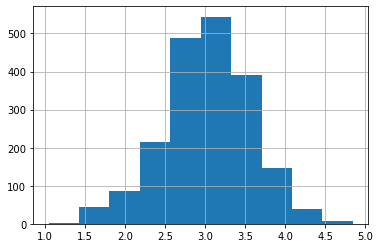

In [71]:
np.log10(df_twitter_archive_master.retweet_count).hist();

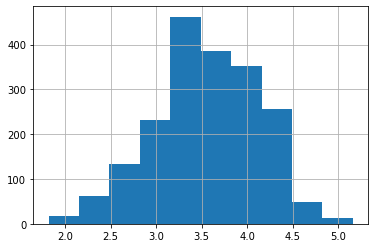

In [72]:
np.log10(df_twitter_archive_master.favorite_count).hist();

- **scatter plot of retweet_count and favorite_count**

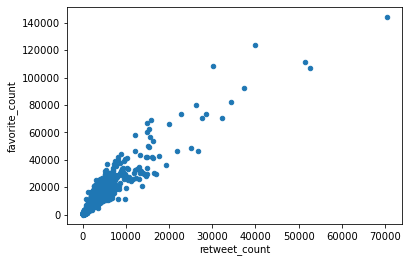

In [73]:
df_twitter_archive_master.plot(x='retweet_count', y='favorite_count', kind='scatter');

# The End